# Final Exam Review

The below questions are examplary of the type of questions we may ask you on the final exam. You will do several complete analysis of two different fMRI data sets. The first data set comes from the motor localizer experiment you've used on many previous assignments, which used a block design. This dataset is best analyzed using contrasts. The second data set comes from an event-related design where subjects viewed a large number of naturalistic images, and is best analyzed using encoding models. 

Here is a [link](http://gallantlab.org/_downloads/2009.Naselaris.etal.pdf) to the paper that used these data if you would like to learn more. Also, here is a [link](http://gallantlab.org/index.php/publications/) to the Gallant lab's website where you can download many of the influential papers from that lab which use encoding models.

# Motor Localizer Experiment

**(1)** Import all the packages you need here. Every time you find yourself needing a package, import it here. Do not import more packages than you need.

In [16]:
import numpy as np
import nibabel
import cortex
from nistats.hemodynamic_models import glover_hrf as create_hrf
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
%matplotlib inline

**(2)** **Design matrix** Load `/data/cogneuro/fMRI/motor/motorloc_experimental_conditions.npy` and make a stimulus and a response design matrix out of the motor localizer task labels. Before creating the matrices, **remove the first 10 and the last 15 labels**.

In [27]:
labels = np.load("/data/cogneuro/fMRI/motor/motorloc_experimental_conditions.npy")[10:-15]
unique_labels = np.unique(labels)
hrf = create_hrf(tr=2, oversampling=1, time_length=32)
response_vectors = []
stimulus_vectors = []
for category in unique_labels:
    stimulus_vector = labels == category
    convolved_stimulus_vector = np.convolve(stimulus_vector, hrf)
    response_vectors.append(convolved_stimulus_vector[:len(stimulus_vector)])
    stimulus_vectors.append(stimulus_vector)
response_design = np.stack(response_vectors, axis=1)
stimulus_design = np.stack(stimulus_vectors, axis=1)
    

**(3)** **Data** Write a function that can load, and optionally mask and z-score, fMRI brain data. Get a `cortical` mask for `s01` for the `catloc` transformation. Use it to load, mask (get a `cortical` mask from pycortex for `s01`) and zscore `/data/cogneuro/fMRI/motor/s01_motorloc.nii.gz`. If using this function you get a warning about division by 0, make sure you modify your function to remove this, e.g. by dividing by the standard deviation augmented by a very small number.

Store the output in `motor_data`. Make sure to **remove the first ten and the last 15 data points**.

In [26]:
def load_nifti(filename, mask=None, zscore=True):
    img = nibabel.load(filename)
    data = img.get_data().T
    if mask is not None:
        data = data[:, mask]
    if zscore:
        data -= data.mean(axis=0)
        data /= data.std(axis=0) + 1e-10
    return data

mask = cortex.db.get_mask("s01", "catloc", "cortical")
motor_data = load_nifti("/data/cogneuro/fMRI/motor/s01_motorloc.nii.gz", mask=mask)[10:-15]
motor_data.shape

(300, 38543)

**(4)** Fit a linear model with the response design matrix as the independent variables and the voxel data as dependent variables.

In [28]:
lr = LinearRegression().fit(response_design, motor_data)

**(5)** Compute the contrasts `eyes vs rest`, `hand vs rest`, `foot vs rest`, `speak vs rest`, `speak vs mouth` and display them on flatmaps. Give them appropriate titles

**Note:** If nothing is showing, remember to import the relevant visualization packages above.

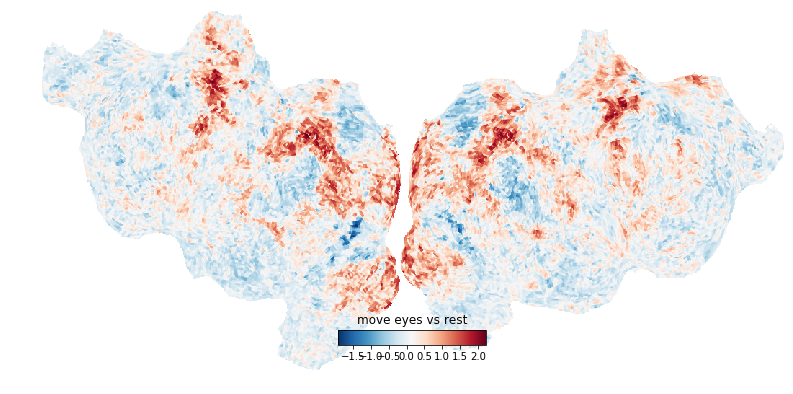

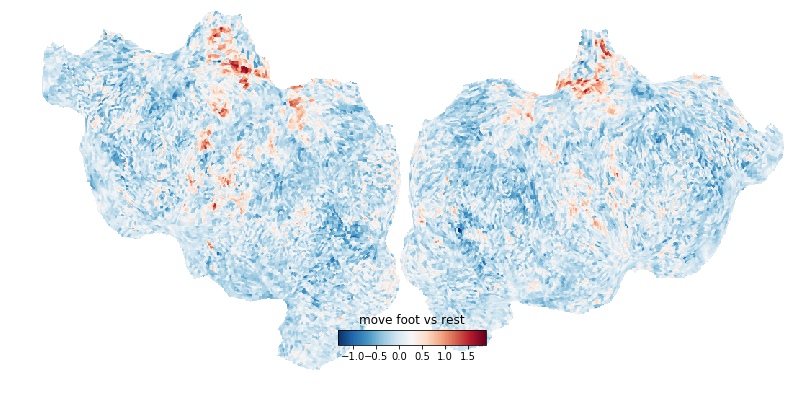

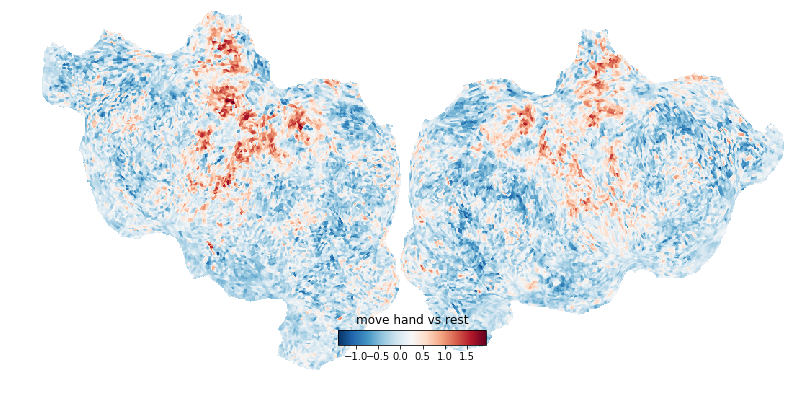

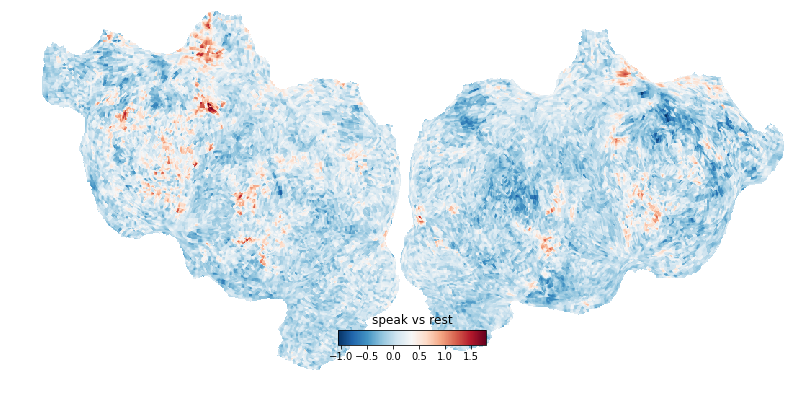

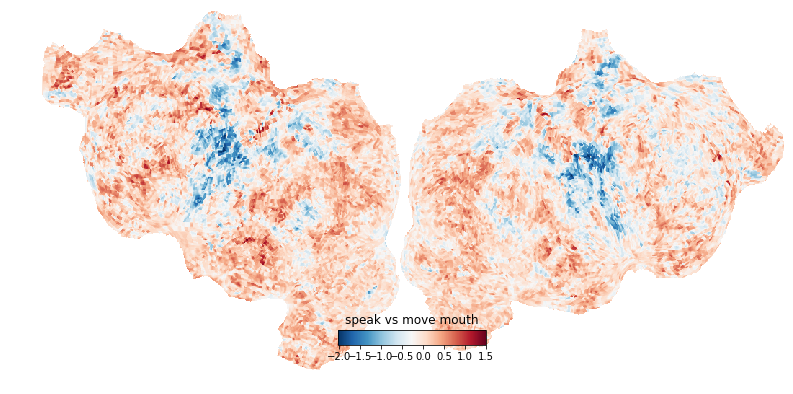

In [29]:
contrast_indices = [(0, 4), (1, 4), (2, 4), (5, 4), (5, 3)]
for pos_ind, neg_ind in contrast_indices:
    contrast = lr.coef_[:, pos_ind] - lr.coef_[:, neg_ind]
    cortex.quickflat.make_figure(cortex.Volume(contrast, 's01', 'catloc'))
    plt.title("{} vs {}".format(unique_labels[pos_ind], unique_labels[neg_ind]))
pass

**(6)** Write a function `shuffle_blocks(x)` that can shuffle a stimulus design matrix by blocks. You'll use this function to do a permutation test in the next question. 

**CONCEPTUAL QUESTION:**
Why is it necessary to shuffle the design matrix by blocks?

In this function (which takes `x` and `block_size=10` as arguments), create an `np.arange` of length `x.shape[0]`, and call it `indices`. 

Then reshape this array to have the shape `(-1, block_size)` (note that this is only possible if `block_size` divides `x.shape[0]`). 

Next, use `np.random.shuffle` to shuffle the indices (note that `np.random.shuffle` modifies the array `indices`).

Finally, reshape `indices` back to its original 1D shape with `.reshape(-1)`. Now you can use this `indices` array to shuffle `x`.

If you have troubles with this, use the function written below. You will need to change it into a code cell, from a markdown cell, by selecting the cell (the cell outline should be blue) and pressing `Y`.

In [22]:
def shuffle_blocks(x, block_size=10):
    indices = np.arange(len(x))
    indices = indices.reshape(-1, block_size)
    np.random.shuffle(indices)
    indices = indices.reshape(-1)
    return x[indices]


**(7)** Do a permutation test on the `eyes vs rest` contrast you calculated above using 100 `RESAMPLES`. Write the permutation test code by hand, do not use the function from class. You should end up with a 1-D vector, which is the length of the number of cortical voxels, and contains p-values indicating significance for each voxel.

Plot the negative log-p-values (`-np.log(pvalues)`) on a flatmap. 

**CONCEPTUAL QUESTION:**
Why is it easier to see the p-values on the flatmap if we use the negative log of the p-values?

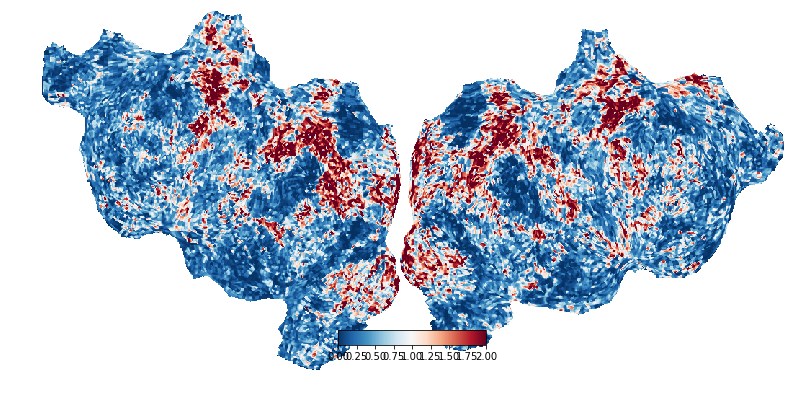

In [33]:
n_resamples = 100
eyes_vs_rest_not_permuted = lr.coef_[:, 0] - lr.coef_[:, 4]

permutation_signifcant_count = np.zeros(eyes_vs_rest_not_permuted.shape, dtype='int')

for rs in range(n_resamples):
    shuffled_stimulus_matrix = shuffle_blocks(stimulus_design)
    shuffled_response_vectors = []
    for i in range(shuffled_stimulus_matrix.shape[1]):
        shuffled_response_vectors.append(np.convolve(shuffled_stimulus_matrix[:, i], hrf)[:len(stimulus_design)])
    shuffled_response_design = np.stack(shuffled_response_vectors, axis=1)
    shuffled_lr = LinearRegression().fit(shuffled_response_design, motor_data)
    shuffled_contrast = shuffled_lr.coef_[:, 0] - shuffled_lr.coef_[:, 4]
    permutation_signifcant_count[shuffled_contrast > eyes_vs_rest_not_permuted] += 1

p_values = (permutation_signifcant_count + 1) / (n_resamples + 1)
cortex.quickflat.make_figure(cortex.Volume(-np.log10(p_values), 's01', 'catloc'))
pass

# Event-Related Image Experiment

For this question you might **need to restart your kernel due to a lack of memory.** If you do restart the kernel, you will need to re-import all the packages and commands you need once again.

Run the cell below which will create a more memory efficient version of LinearRegression that you can use for this review.

## Semantic Encoding Models

**(1) Import Packages** Import all the packages you need here. Every time you find yourself needing a package, import it here. Do not import more packages than you need.

In [34]:
import numpy as np
import h5py
import cortex

import matplotlib.pyplot as plt
%matplotlib inline

In [35]:
## If you need a memory-efficient regression, un-raw-format this cell
from sklearn.linear_model import LinearRegression as SkLinearRegression
from sklearn.base import BaseEstimator
import tempfile

class LinearRegression(BaseEstimator):
    
    def __init__(self, block_size=5000, use_pinv=True, lr_args=None, fit_intercept=True, 
                 memmap_coefs=True, verbose=1):
        self.block_size = block_size
        self.use_pinv = use_pinv
        self.lr_args = lr_args
        self.fit_intercept = fit_intercept
        self.verbose = verbose
        self.memmap_coefs = memmap_coefs
    
    def zeros(self, shape, dtype='float32'):
        if isinstance(shape, int):
            shape = shape,
        if self.memmap_coefs is False:
            return np.zeros(shape, dtype=dtype)
        else:
            if self.memmap_coefs is True:
                file_id, memmap_file = tempfile.mkstemp()
            else:
                # if filename specified
                memmap_file = open(self.memmap_coefs, 'r+')
            memmap = np.memmap(memmap_file, dtype=dtype, shape=tuple(shape))
            memmap[:] = 0.
            return memmap
    
    def fit(self, X, Y):
        self.y_ndim = Y.ndim

        if Y.ndim == 1:
            Y = Y.reshape(-1, 1)

        self.coef_ = self.zeros([Y.shape[1], X.shape[1]])
        if self.fit_intercept:
            self.intercept_ = self.zeros(Y.shape[1])

        if self.use_pinv:
            if self.fit_intercept:
                X_pinv = np.linalg.pinv(np.hstack([X, np.ones_like(X[:, 0:1])]))
            else:
                X_pinv = np.linalg.pinv(X)

            for i in range(0, Y.shape[1], self.block_size):
                weights = X_pinv.dot(Y[:, i:i + self.block_size])
                self.coef_[i:i + self.block_size] = weights[:X.shape[1]].T
                if self.fit_intercept:
                    self.intercept_[i:i + self.block_size] = weights[-1]
                if self.verbose > 0:
                    print(".", end="")
        else:
            lr_args = {} if self.lr_args is None else lr_args
            lr = SkLinearRegression(fit_intercept=self.fit_intercept, **lr_args)
            for i in range(0, Y.shape[1], self.block_size):
                lr.fit(X, Y[:, i:i + self.block_size])
                self.coef_[i:i + self.block_size] = lr.coef_
                if self.fit_intercept:
                    self.intercept_[i:i + self.block_size] = lr.intercept_
                if self.verbose > 0:
                    print(".", end="")
        return self
    
    def predict(self, X):
        p = self.zeros((X.shape[0], self.coef_.shape[0]))
        for i in range(0, self.coef_.shape[0], self.block_size):
            p[:, i:i + self.block_size] = X.dot(self.coef_.T[:, i:i + self.block_size])
            if hasattr(self, 'intercept_') and self.fit_intercept:
                p[:, i:i + self.block_size] = p[:, i:i + self.block_size] + self.intercept_[i:i + self.block_size]
        if self.y_ndim == 1:
            p = p.ravel()
        return p
                
            

def z_score(x):
    x = x - x.mean(axis=0)
    x = x / (x.std(axis=0) + 1e-18)
    return x

def correlate(x, y, block_size=5000):
    if x.ndim == 1:
        x = x.reshape(-1, 1)
    if y.ndim == 1:
        y = y.reshape(-1, 1)
    
    output = np.zeros(x.shape[1])
    for i in range(0, x.shape[1], block_size):
        x_z = z_score(x[:, i:i + block_size])
        y_z = z_score(y[:, i:i + block_size])
        output[i:i + block_size] = np.mean(x_z*y_z, axis=0)
    return output

**(2) Load Data** Now you can load the brain data. This file is stored in `HD5` format, which you aren't responsible for knowing for the exam (we will give you code if you need to load an `HD5` file on the final). As in the lecture, use `h5py` to create a `h5py.File` passing it the filename `/data/cogneuro/fMRI/images/s04_color_natims_data.hdf` as the only argument, and call it `data_file`. Get the training data using the command `data_file['est][:]`, and the test data using the command `data_file['val'][:]` and store them in `Ytrain` and `Ytest` respectively.

If you can't figure this out, feel free to run the below cell to load the data. You will need to change it to a code cell, from a markdown cell, by selecting it and pressing `y`.

In [36]:
data_file = h5py.File("/data/cogneuro/fMRI/images/s04_color_natims_data.hdf")
Ytrain = data_file['est'][:]
Ytest = data_file['val'][:]

data_file = h5py.File("/data/cogneuro/fMRI/images/s04_color_natims_data.hdf")
Ytrain = data_file['est'][:]
Ytest = data_file['val'][:]

**(3) Data Cleaning** 

**NOTE** This will not be on the exam, it is only for extra practice with applying array masking to a new problem. You can simply run the cell below, which will do the same thing. 

Creating a mask for the `nan`-voxels and removing the `nan`s. The floating-point value `nan` (*not a number*) indicates where values are corrupted. In computations it can cause lots of problems: Essentially, any number that gets multiplied by or added to `np.nan` becomes `np.nan`. So often a whole array can become `np.nan` if complicated operations are performed on it. To avoid this, we will mask them out. There are two options to do this. One is to compute a binary mask and use it to remove all the voxels containing a `np.nan` value. This modifies the shape of our data (fewer columns) and then pycortex won't want to plot maps of it. The other option is to keep track of where the `np.nan` values are, replace them with random values for computations, and then set them back to `np.nan` or something else in the result. This is what we choose to do here.

This is a convenient way to revise *masking*, also.

Use `np.isnan` to create two arrays `Ytrain_nan`, `Ytest_nan` indicating where the nans are in `Ytrain` and `Ytest`. Sum both of these along `axis=0` to get a count of nans per column. Call the outputs `Ytrain_nan_count` and `Ytest_nan_counts`. Now sum up `Y_train_nan_counts` and `Y_test_nan_counts` and store the result in `total_nan_counst`. This counts how many nans there are per column in total across train and test sets. We would like to discard any voxel that has more than 0 nans. In order to identify them, create `nan_mask`, a boolean array indicating where `total_nan_counts` is greater than 0.

You will now replace the columns containing nans with random values. In order to do this, first let's count the total number of voxels featuring at least one nan by summing up `nan_mask`. Call the output `num_nans`.

Now create two arrays of random values: `randn_train` of shape `(len(Ytrain), num_nans)` and `randn_test` of shape `(len(Ytest), num_nans)`.

Now use masking in the second axis to set the columns of `Ytrain` and `Ytest` that contain nans to `randn_train` and `randn_test`.

In [37]:
Ytrain_nan = np.isnan(Ytrain)
Ytest_nan = np.isnan(Ytest)
Ytrain_nan_counts = Ytrain_nan.sum(axis=0)
Ytest_nan_counts = Ytest_nan.sum(axis=0)
total_nan_counts = Ytrain_nan_counts + Ytest_nan_counts
nan_mask = total_nan_counts > 0
num_nans = nan_mask.sum()

randn_train = np.random.randn(len(Ytrain), num_nans)
randn_test = np.random.randn(len(Ytest), num_nans)

Ytrain[:, nan_mask] = randn_train
Ytest[:, nan_mask] = randn_test

If you didn't manage to complete this exercise, you can run this code, which will remove the `nan`s and z-score the data:

**(4) Z-scoring** Simply z-score `YTrain` and `YTest`, but don't use the `zscore` function from `scipy.stats.`. Instead, just use the `mean` and `std` functions on the arrays to do the `zscoring` "manually". Make sure they happen in-place (using `-=` and `/=` for subtraction of mean and divison by standard deviation. Add `1e-8` to the standard deviation before dividing.)

In [39]:
Ytrain -= Ytrain.mean(0)
Ytrain /= Ytrain.std(0) + 1e-7
Ytest -= Ytest.mean(0)
Ytest /= Ytest.std(0) + 1e-7

**(5) Loading Design Matrices**  The 3-category and 19-category design matrices are stored in `/data/cogneuro/fMRI/images/color_natims_features_3cat.hdf` and `/data/cogneuro/fMRI/images/color_natims_features_19cat.hdf` respectively. Again, use `h5py.File` to load them, and call them `stim_file_3cat` and `stim_file_19cat` respectively. 

To extract the data arrays from these files for the 3 semantic category model, use the command `stim_file_3cat['est'][:]` for the training data, and call it `Xtrain_3cat`. For the test data use the command `stim_file_3cat['val'][:]` and call the resulting array `Xtest_3cat`. Do the analogous thing for the 19 semantic category model using `stim_file_19cat`.

In [40]:
stim_file_19cat = h5py.File("/data/cogneuro/fMRI/images/color_natims_features_19cat.hdf")
stim_file_3cat = h5py.File("/data/cogneuro/fMRI/images/color_natims_features_3cat.hdf")

Xtrain_3cat = stim_file_3cat['est'][:]
Xtrain_19cat = stim_file_19cat['est'][:]

Xtest_3cat = stim_file_3cat['val'][:]
Xtest_19cat = stim_file_19cat['val'][:]


**(6) Fitting Encoding Models** Create two `sklearn` `LinearRegression` models, one for the 3-category and one for the 19-category models. Call them `lr_3cat` and `lr_19cat` respectively. Fit both of them to the training data using their respective training set design matrices.

**Note:** As mentioned in class, the brain data contains *response amplitudes* for each presented image. This means that the HRF delay has already been accounted for and we can compute activations directly with the stimulus design matrix, meaning we don't need to convolve it with the HRF.

**CONCEPTUAL QUESTION:** What is the name of the operation that is used to create the response amplitudes from the BOLD data?

In [41]:
lr_3cat = LinearRegression()
lr_19cat = LinearRegression()

lr_3cat.fit(Xtrain_3cat, Ytrain)
lr_19cat.fit(Xtrain_19cat, Ytrain)

............................

LinearRegression(block_size=5000, fit_intercept=True, lr_args=None,
         memmap_coefs=True, use_pinv=True, verbose=1)

**(7) Calculate Prediction Accuracy** Compute the predictions of the two encoding models on the test data. To do that, you'll use the models called `lr_3cat` and `lr_19cat` that you just fit. Store the predictions in two names called `Ypred_3cat` and `Ypred_19cat`. Then calculate the prediction accuracy by correlating the actual brain data (response amplitudes in this case) with the predicted brain data you just calculated. Use the `correlate` function that you loaded in the cell above, which is more memory efficient. Call the prediction accuracies `pred_acc_3cat` and `pred_acc_19cat`.

In [42]:
Ypred_3cat = lr_3cat.predict(Xtest_3cat)
Ypred_19cat = lr_19cat.predict(Xtest_19cat)

pred_acc_3cat = correlate(Ytest, Ypred_3cat)
pred_acc_19cat = correlate(Ytest, Ypred_19cat)

**(8) Plot Prediction Accuracy Maps** Use `pycortex` to plot both prediction accuracy maps. Use subject `s04` and transformation `color_natims` as options to the cortex.Volume function, and use the colormap `cmap='hot'` as an argument to the `make_figure` function.

**Note:** If the figure does not show up, make sure you import the necessary python modules for visualizing flatmaps, and that you tell Python to plot the figure in this notebook.

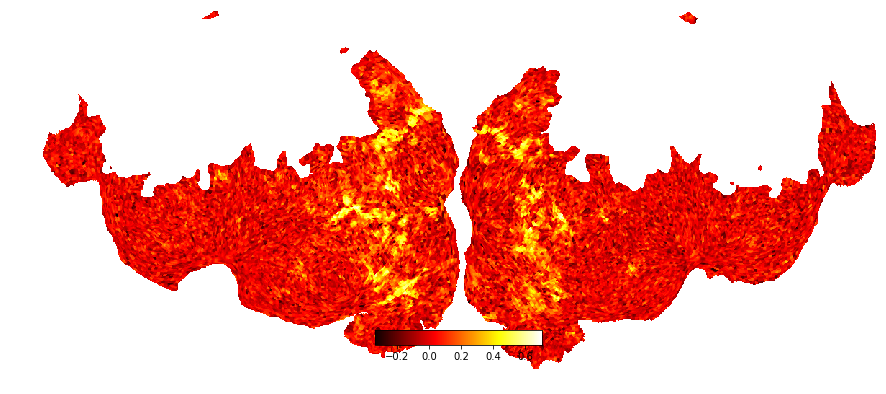

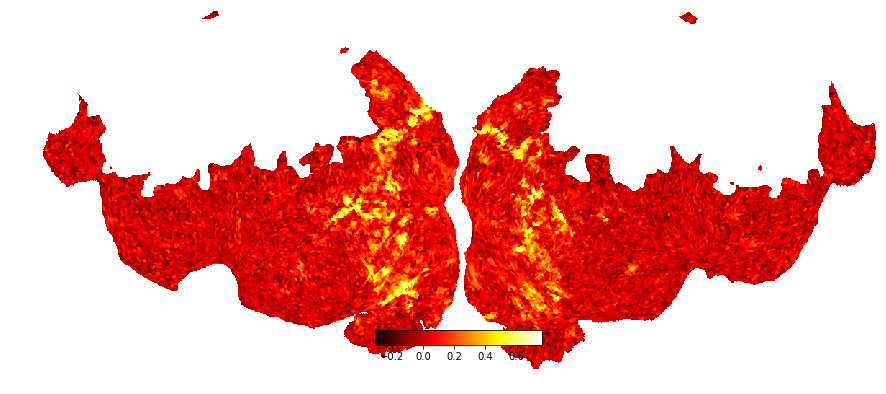

In [43]:
cortex.quickflat.make_figure(cortex.Volume(pred_acc_3cat, 's04', 'color_natims', cmap='hot'))
cortex.quickflat.make_figure(cortex.Volume(pred_acc_19cat, 's04', 'color_natims', cmap='hot'))
pass

**(9) Model Performance Comparison** Let's take a look at the differences in model performance. There are several ways to do this. We learned in class we can make a scatter plot. We can also use flatmaps to compare performance. Let's start by create a scatter plot comparing the prediction accuarcies of the 3 and 19 category semantic models.
To do this, simply create a scatter plot like you've done before, and give it the two prediction accuracy vectors you created above. 

To make sure that the axes have equal scales, use the command `plt.axis('square')`.

Draw a line that represents equal performance on both models using the command `plt.plot([-1,1],[-1,1])`.

Finally, label the x and y axis labels with the name of the encoding model (3 or 19 semantic category) being displayed on each axis.

**CONCEPTUAL QUESTION** Which model has a higher prediction accuracy overall (meaning on average across all voxels)? How can you tell? 

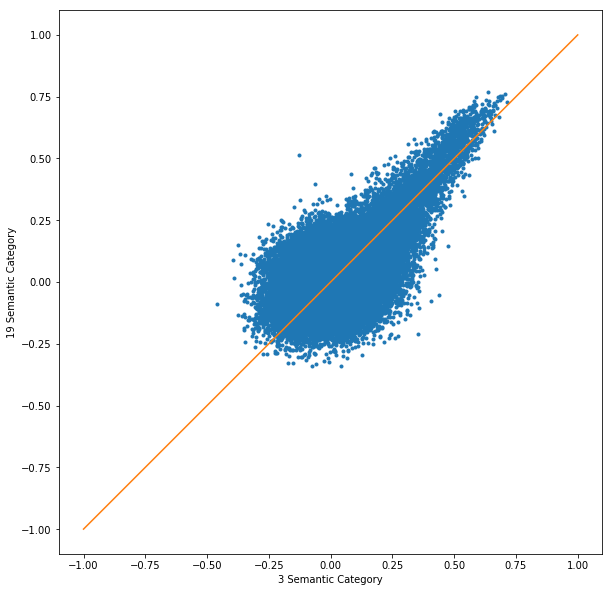

In [44]:
fig = plt.figure(figsize=(10,10))
plt.plot(pred_acc_3cat, pred_acc_19cat, '.')
plt.plot([-1,1],[-1,1])
plt.axis('square')
plt.xlabel('3 Semantic Category')
_ = plt.ylabel('19 Semantic Category')

**(10) Model Comparison: Flatmaps** Now let's compare the models on a flatmap, so we can exactly where on the cortex the two models predict better. If we subtract the prediction accuracy of the 3 category model from the prediction accuracy of the 19 category model, then positive values indicate where the 19 category model had better performance, and negative values indicate where the 3 category model had better performance.

Calculate `pred_acc_19cat - pred_acc_3cat` (and it's converse showing where the 3 category is better than the 19 category model) and store those differences in two names called `pred_acc_diff_3cat_better` and `pred_acc_diff_19cat_better` respectively. 

Then plot both difference vectors on flat maps using `vmin=0`, `vmax=0.3` and `cmap='hot'`.

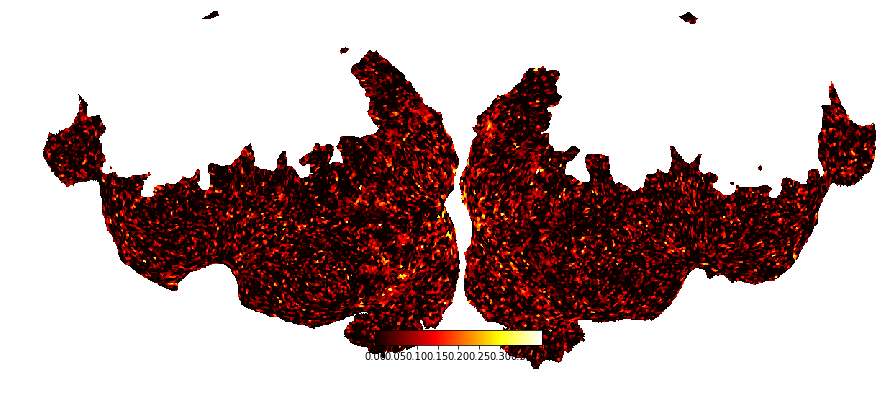

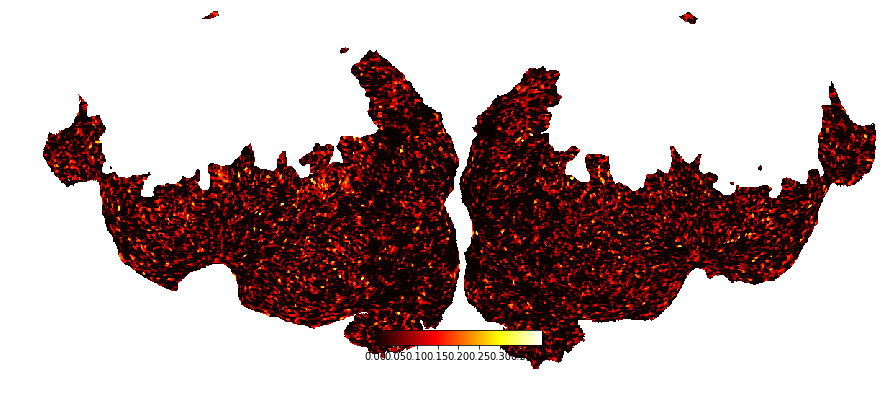

In [45]:
pred_acc_diff_19cat_better = pred_acc_19cat-pred_acc_3cat
pred_acc_diff_3cat_better = pred_acc_3cat-pred_acc_19cat

cortex.quickflat.make_figure(cortex.Volume(pred_acc_diff_19cat_better, 's04', 'color_natims', vmin=0, vmax=.4, cmap='hot'))
cortex.quickflat.make_figure(cortex.Volume(pred_acc_diff_3cat_better, 's04', 'color_natims', vmin=0, vmax=.4, cmap='hot'))
pass

**(11)** Both of these maps seems to say that the 19-category model is better in later visual cortex where there is high predictive accuracy (just by qualitatively comparing the areas where the 19 is better with the prediction accuracy maps above). These maps also show a very "salt and pepper" pattern everywhere else in the brain. This map is not very helpful to determine whether there are any voxels that are well-predicted by the 3-category model which are also better predicted by the 3-category model than the 19-category model, which is the more interesting question. Let's try and answer this second question.

Make a boolean array `predicted_by_3cat` such that all voxels which the 3-category model has prediction accuracy of `.35` or higher have the value `True`.

Then set all values in `pred_acc_diff_3cat_better` for which `predicted_by_3cat` is not `True` to `0`. You can use masking for this.

Now plot `pred_acc_diff_3cat_better` on a flatmap, using `vmin=0`, `vmax=0.2` and `cmap='hot'`. This will make all the voxels black that are either not well-predicted by the 3 category model, or well predicted by the 3-category model, but better predicted by the 19 category model. Thus, the voxels colored in anything other than black are both well predicted by the 3-category model and better predicted by the 3-category model than the 19 category model.

Now do a similar thing for the 19-category model. You should now see that in the regions that are well predicted, the 19 category model does a much better job than the 3 category model.

**Note:** You can make the figure contain the regions of interest (ROIs) for reference, by setting `with_rois=True` in the flatmap command.

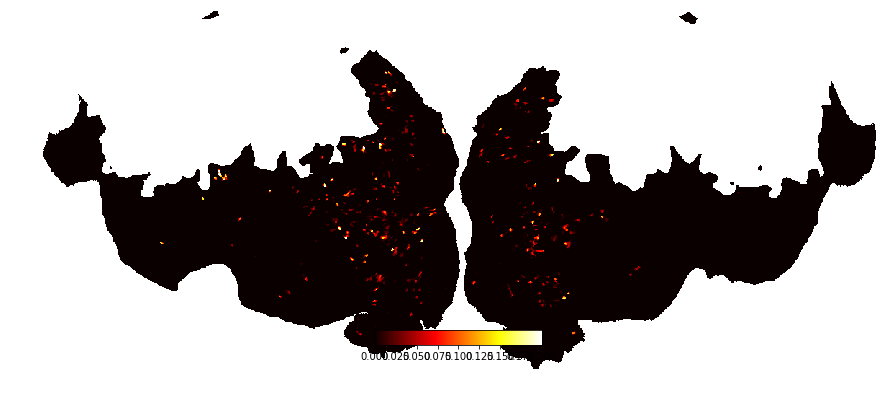

In [53]:
predicted_by_3cat = pred_acc_3cat > .35
pred_acc_diff_3cat_better[~predicted_by_3cat] = 0
cortex.quickflat.make_figure(cortex.Volume(pred_acc_diff_3cat_better, 's04', 'color_natims',  vmin=0, vmax=.2, cmap='hot'))
pass

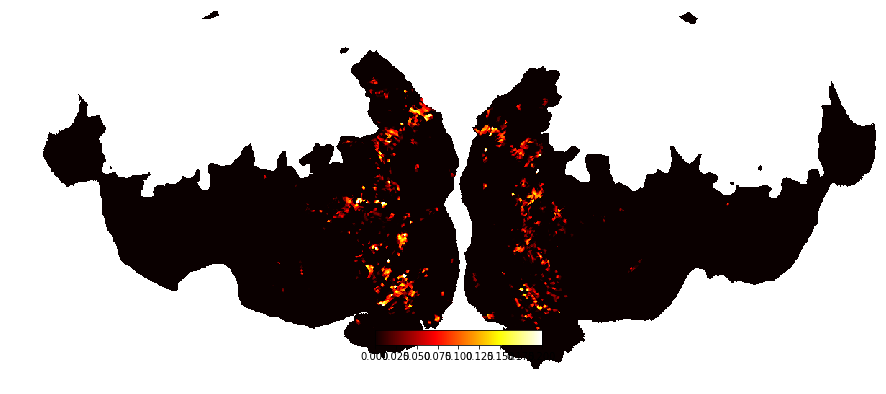

In [54]:
predicted_by_19cat = pred_acc_19cat > .35
pred_acc_diff_19cat_better[~predicted_by_19cat] = 0
cortex.quickflat.make_figure(cortex.Volume(pred_acc_diff_19cat_better, 's04', 'color_natims', vmin=0, vmax=.2, cmap='hot'))
pass

## Student Generated Encoding Models

In this exercise you will use the features you and your classmates tagged in homework 11 to create encoding models from features you all generated!

### Reward Features
**(1) Load Data** In these tags, images were rated according to how rewarding they were to the viewer. Load the  tags from `reward_design.npy` and the tag values from `reward_column_names.npy`. Print the tag values and the first 3 rows of the design.

In [55]:
reward_design = np.load("reward_design.npy")
reward_column_names = np.load("reward_column_names.npy")
print(reward_column_names)
print(reward_design[:3])

['0' '1' '2' '3' '4']
[[0 0 1 0 1]
 [0 0 1 1 0]
 [2 0 0 0 0]]


**(2) Visualize Design Matrix** Visualize `reward_design` using `plt.imshow` with a reasonable aspect ratio. Observe that per image there are two tags, sometimes coincident, sometimes not. Put the reward column names as `xticks` on the image.

([<matplotlib.axis.XTick at 0x7fb9a52b4278>,
 <a list of 5 Text xticklabel objects>)

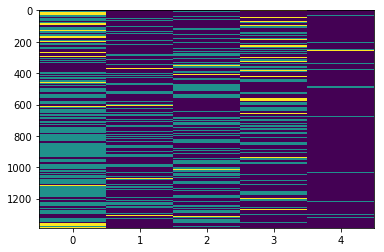

In [56]:
plt.imshow(reward_design, aspect='auto')
plt.xticks(np.arange(len(reward_column_names)), reward_column_names)

**(3) Split into Train and Test** Split the design matrix into train and test: The first 126 rows are `test` and should be called `X_reward_test`. The remaining `1260` rows are `train` and should be called `X_reward_train`.

In [57]:
X_reward_test = reward_design[:126]
X_reward_train = reward_design[126:]

**(4) Fit Model** Fit a model `lr_reward` (use `fit_intercept=False` for this part when creating the `LinearRegression`) using `X_reward_train`. Then predict using `X_reward_test`.

In [58]:
lr_reward = LinearRegression(fit_intercept=False)
lr_reward.fit(X_reward_train, Ytrain)
pred_reward = lr_reward.predict(X_reward_test)

..............

**(5) Plot Prediction Accuracy** Plot the prediction accuracy on a flatmap using `vmin=0`, `vmax=0.3` and `cmap='hot'`. Use `with_rois=True` to have an ROI reference.

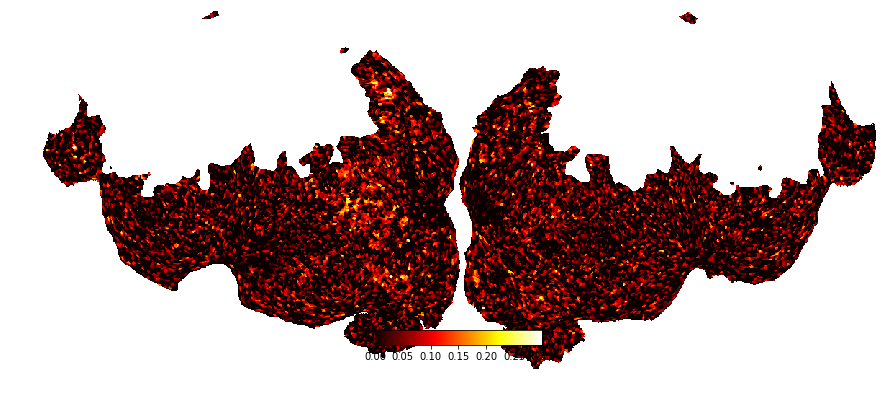

In [59]:
pred_acc_reward = correlate(Ytest, pred_reward)
_ = cortex.quickflat.make_figure(cortex.Volume(pred_acc_reward, 's04', 'color_natims', vmin=0, vmax=.3, cmap='hot'))

**(6) Continuous Model** Instead of the model where each column indicates a choice of rewardingness, let's turn this into a continuous value: For each row in `reward_design`, identify the values that are tagged, average them, and write them into a 1-column array called `reward_design_continuous`.

In [60]:
reward_design_continuous = np.zeros([reward_design.shape[0], 1])
reward_values = np.array([0, 1, 2, 3, 4])
for i in range(len(reward_design)):
    reward_votes = reward_design[i]
    reward_average = (reward_votes * reward_values).mean()
    reward_design_continuous[i] = reward_average

**(7) Split into Test and Train** Split `reward_design_continuous` into `X_reward_continuous_train` and `X_reward_continuous_test` as above.

In [61]:
X_reward_continuous_train = reward_design_continuous[126:]
X_reward_continuous_test = reward_design_continuous[:126]

**(8) Fit Continuous Model** Fit a linear regression `lr_reward_continuous` to `X_reward_continuous_train` and `Xtrain` and predict on `X_reward_continuous_test`. Calculate the prediction accuracy and plot it as a hot colormap.

In [62]:
lr_reward_continuous = LinearRegression()
lr_reward_continuous.fit(X_reward_continuous_train, Ytrain)
pred_reward_continuous = lr_reward_continuous.predict(X_reward_continuous_test)

..............

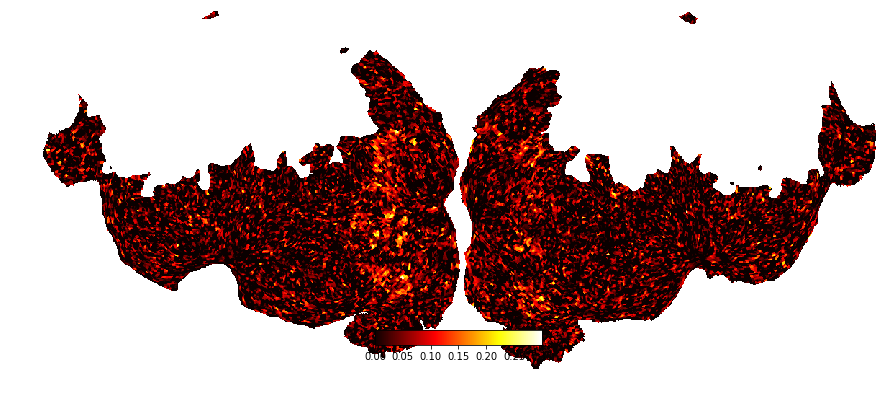

In [63]:
pred_acc_reward_continuous = correlate(Ytest, pred_reward_continuous)
_ = cortex.quickflat.make_figure(cortex.Volume(pred_acc_reward_continuous, 's04', 'color_natims', vmin=0, vmax=0.3, cmap='hot'))

**(9) Model Comparison** Compare the two above models visually by plotting both prediction accuracies in a scatter plot. Don't forget to make the axes square and draw a line indicating equal performance, just as you did when you compared the 3 and 19 category semantic models above.

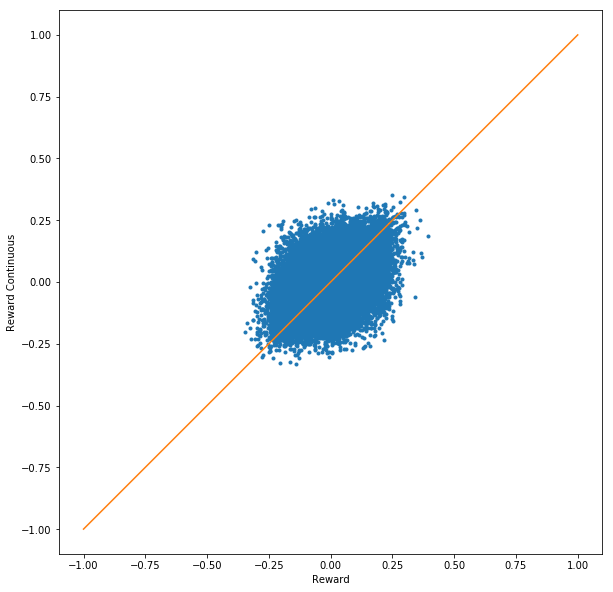

In [64]:
fig = plt.figure(figsize=(10,10))
plt.plot(pred_acc_reward, pred_acc_reward_continuous, '.')
plt.plot([-1,1],[-1,1])
plt.axis('square')
plt.xlabel('Reward')
_ = plt.ylabel('Reward Continuous')

### Curvature Features
In these tags, images are tagged to be either having `more curvature`, `more straight lines` or `mixed`.

**(1) Design Matrix Loading and Plotting** Load `curve_design.npy` and `curve_design_columns.npy` into `curve_design` and `curve_design_columns`. Display `curve_design` with `curve_design_columns` as `xticks`.

**Note:** There are up to 3 tags per person, but not everywhere. So we divided each row by the number of tags it has.

([<matplotlib.axis.XTick at 0x7fb9a5422470>,
 <a list of 3 Text xticklabel objects>)

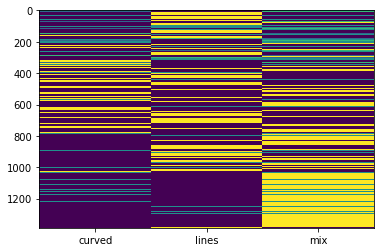

In [65]:
curve_design = np.load('curve_design.npy')
curve_design_columns = np.load('curve_design_columns.npy')
plt.imshow(curve_design, aspect='auto')
plt.xticks(range(len(curve_design_columns)), curve_design_columns)

**(2) Model Fit & Prediction Accuracy Map** Split curve_design into `X_curve_train` and `X_curve_test` (`[126:]` and `[:126]`), fit a linear regression `lr_curve` to the data, obtain the predictions on the test set, compute the prediction accuracy `pred_acc_curve` and plot it on a flatmap.

..............

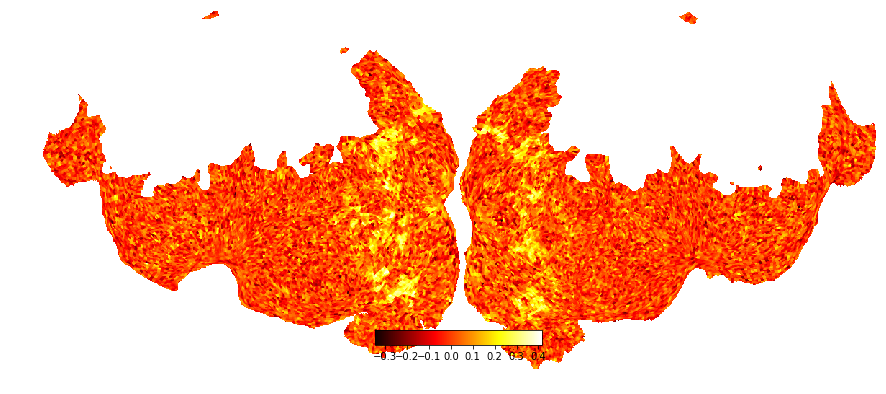

In [66]:
X_curve_train = curve_design[126:]
X_curve_test = curve_design[:126]

lr_curve = LinearRegression()
lr_curve.fit(X_curve_train, Ytrain)
pred_curve = lr_curve.predict(X_curve_test)
pred_acc_curve = correlate(Ytest, pred_curve)

_ = cortex.quickflat.make_figure(cortex.Volume(pred_acc_curve, 's04', 'color_natims', cmap='hot'))

**(3) Model Comparison** Make a scatter plot comparing this curvature model with the 19 category semantic model. 

**CONCEPTUAL QUESTION** Does one model outperform the other everywhere? Or are there 2 groups of voxels, some that seem to do a much better job in the semantic model and some in the curvature model? What does this tell you?

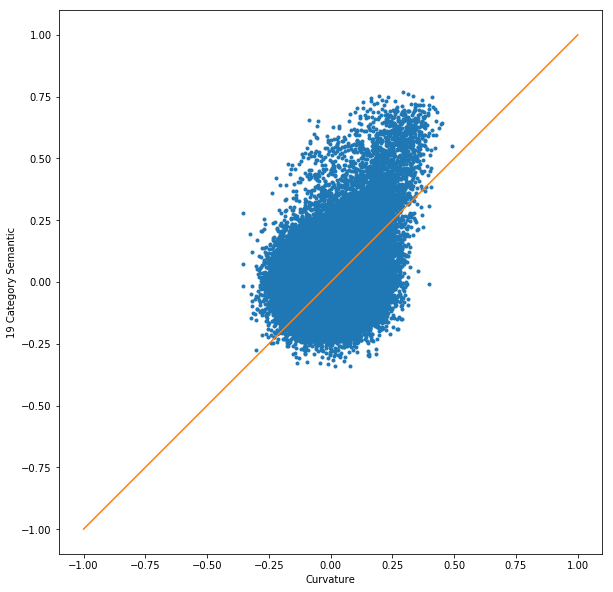

In [67]:
fig = plt.figure(figsize=(10,10))
plt.plot(pred_acc_curve, pred_acc_19cat, '.')
plt.plot([-1,1],[-1,1])
plt.axis('square')
plt.xlabel('Curvature')
_ = plt.ylabel('19 Category Semantic')

### Evoked Emotion Features

In this tag the possible labels are *'Anger', 'Disgust', 'Fear', 'Happiness', 'Neutral', 'Sadness'*, and *'Surprise'*. Each image was tagged up to 3 times, and they are averaged per row to account for different number of tags per image.

**(1) Design Matrix Loading and Plotting** Load `emotion_design.npy` and `emotion_design_columns.npy`. Display `emotion_design` with the tags as `xticks`.

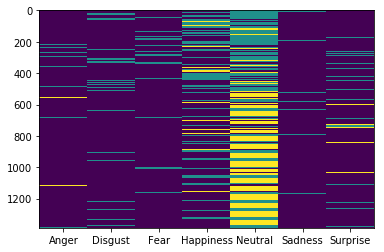

In [68]:
emotion_design = np.load("emotion_design.npy")
emotion_design_columns = np.load("emotion_design_columns.npy")
plt.imshow(emotion_design, aspect='auto')
plt.xticks(range(len(emotion_design_columns)), emotion_design_columns)
pass

**(2) Model Fit & Prediction Accuracy Map** Split the data into `X_emotion_train` and `X_emotion_test` and fit a `LinearRegression` `lr_emotion` to the train data. Get the predictions on the test data and compute the prediction accuracy on the test set. Plot the prediction accuracy on a flatmap.

..............

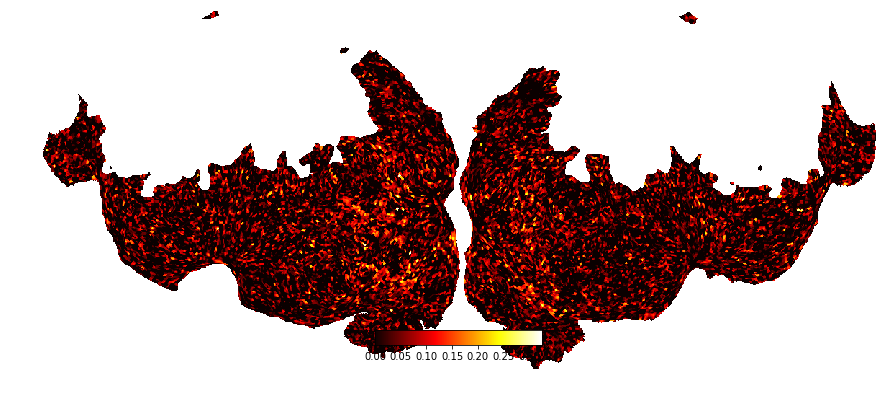

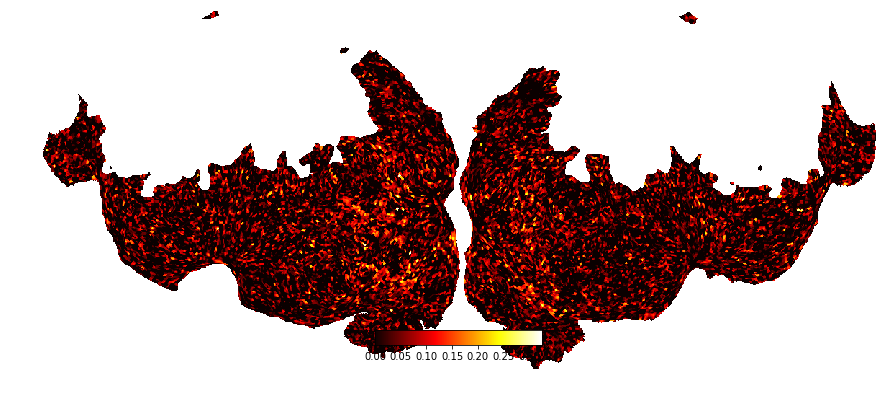

In [69]:
X_emotion_train = emotion_design[126:]
X_emotion_test = emotion_design[:126]

lr_emotion = LinearRegression()
lr_emotion.fit(X_emotion_train, Ytrain)
pred_emotion = lr_emotion.predict(X_emotion_test)
pred_acc_emotion = correlate(Ytest, pred_emotion)

cortex.quickflat.make_figure(cortex.Volume(pred_acc_emotion, 's04', 'color_natims', cmap='hot',vmin=0))

**(3) Model Comparison** Compare the prediction accuracy performance of this model to that of `reward` (or `reward_continuous` if that did bettter) using a scatter plot.

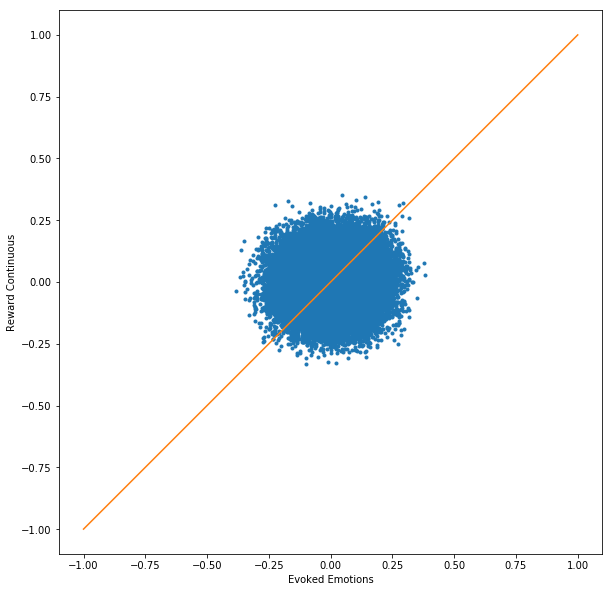

In [70]:
fig = plt.figure(figsize=(10,10))
plt.plot(pred_acc_emotion, pred_acc_reward_continuous, '.')
plt.plot([-1,1],[-1,1])
plt.axis('square')
plt.xlabel('Evoked Emotions')
_ = plt.ylabel('Reward Continuous')